In [1]:
import os

import numpy as np

import plotly.express as px

import torch
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

from minimal_basis.dataset.dataset_reaction import ReactionDataset
from minimal_basis.transforms.absolute import Absolute

from utils import (
    get_test_data_path,
    get_validation_data_path,
    get_train_data_path,
    read_inputs_yaml,
)

from ase import units as ase_units
from ase.data import atomic_numbers, atomic_names

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import wandb
run = wandb.init()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sudarshanvj. Use `wandb login --relogin` to force relogin


In [3]:
inputs = read_inputs_yaml(os.path.join("input_files", "reaction_model.yaml"))

train_json_filename = inputs["train_json"]
validate_json_filename = inputs["validate_json"]
kwargs_dataset = inputs["dataset_options"]
kwargs_dataset["use_minimal_basis_node_features"] = inputs[
    "use_minimal_basis_node_features"
]

train_dataset = ReactionDataset( 
    root=get_train_data_path(),
    filename=train_json_filename,
    basis_filename=inputs["basis_file"],
    **kwargs_dataset
)

validation_dataset = ReactionDataset(
    root=get_validation_data_path(),
    filename=validate_json_filename,
    basis_filename=inputs["basis_file"],
    **kwargs_dataset
)

INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with data.
INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with basis information.
INFO:minimal_basis.dataset.dataset_reaction:Parsing basis information.
Processing...
Done!
INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with data.
INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with basis information.
INFO:minimal_basis.dataset.dataset_reaction:Parsing basis information.
Processing...
Done!


In [4]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

In [7]:
all_mae_norms = []

for idx, data in enumerate(train_loader):

    interpolated_ts_coords = data.pos_interpolated_transition_state.detach().numpy()
    real_ts_coords = data.pos_transition_state.detach().numpy()
    difference_ts_coords = interpolated_ts_coords - real_ts_coords
    norm_difference_ts_coords = np.linalg.norm(difference_ts_coords, axis=1)

    # Mean absolute error
    mae = np.mean(norm_difference_ts_coords)
    all_mae_norms.append(mae)

    # Plot the real and interpolated TS structures
    # with two different colors on the same plot
    fig = px.scatter_3d(
        x=np.concatenate((real_ts_coords[:, 0], interpolated_ts_coords[:, 0])),
        y=np.concatenate((real_ts_coords[:, 1], interpolated_ts_coords[:, 1])),
        z=np.concatenate((real_ts_coords[:, 2], interpolated_ts_coords[:, 2])),
        color=np.concatenate((np.zeros(len(real_ts_coords)), np.ones(len(interpolated_ts_coords)))),
    )

    # Set the title of the plot as the mean absolute error
    fig.update_layout(title=f"MAE of structure prediction: {mae:.3f} Å")
    fig.write_html(f"plots/hamiltonian_model/interpolated_ts_{idx}_mae_{mae:.3f}.html")

# Plot a histogram of the MAE
fig = px.histogram(x=all_mae_norms, nbins=20, template="simple_white")
fig.update_layout(title="MAE structure prediction (Å)")
fig.update_xaxes(title_text="MAE (Å)")
fig.update_yaxes(title_text="Frequency")
fig.write_html("plots/hamiltonian_model/interpolated_ts_mae_histogram.html")

# Reduce the aspect ratio
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
)

fig.show()

In [8]:
artifact_coeff = run.use_artifact('sudarshanvj/reaction/reaction_model:v25', type='model')
artifact_dir_coeff = artifact_coeff.download()
artifact_barrier = run.use_artifact('sudarshanvj/reaction/reaction_model:v22', type='model')
artifact_dir_barrier = artifact_barrier.download()
artifact_forces = run.use_artifact('sudarshanvj/reaction/reaction_model:v16', type='model')
artifact_dir_forces = artifact_forces.download()

wandb: Downloading large artifact reaction_model:v25, 72.93MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.0
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Sum of squares of output: 1.000
Sum of squares of expected: 1.000
Sum of differences: 6.243
Sum of squares of differences: 1.830
Max differences 0.7876762


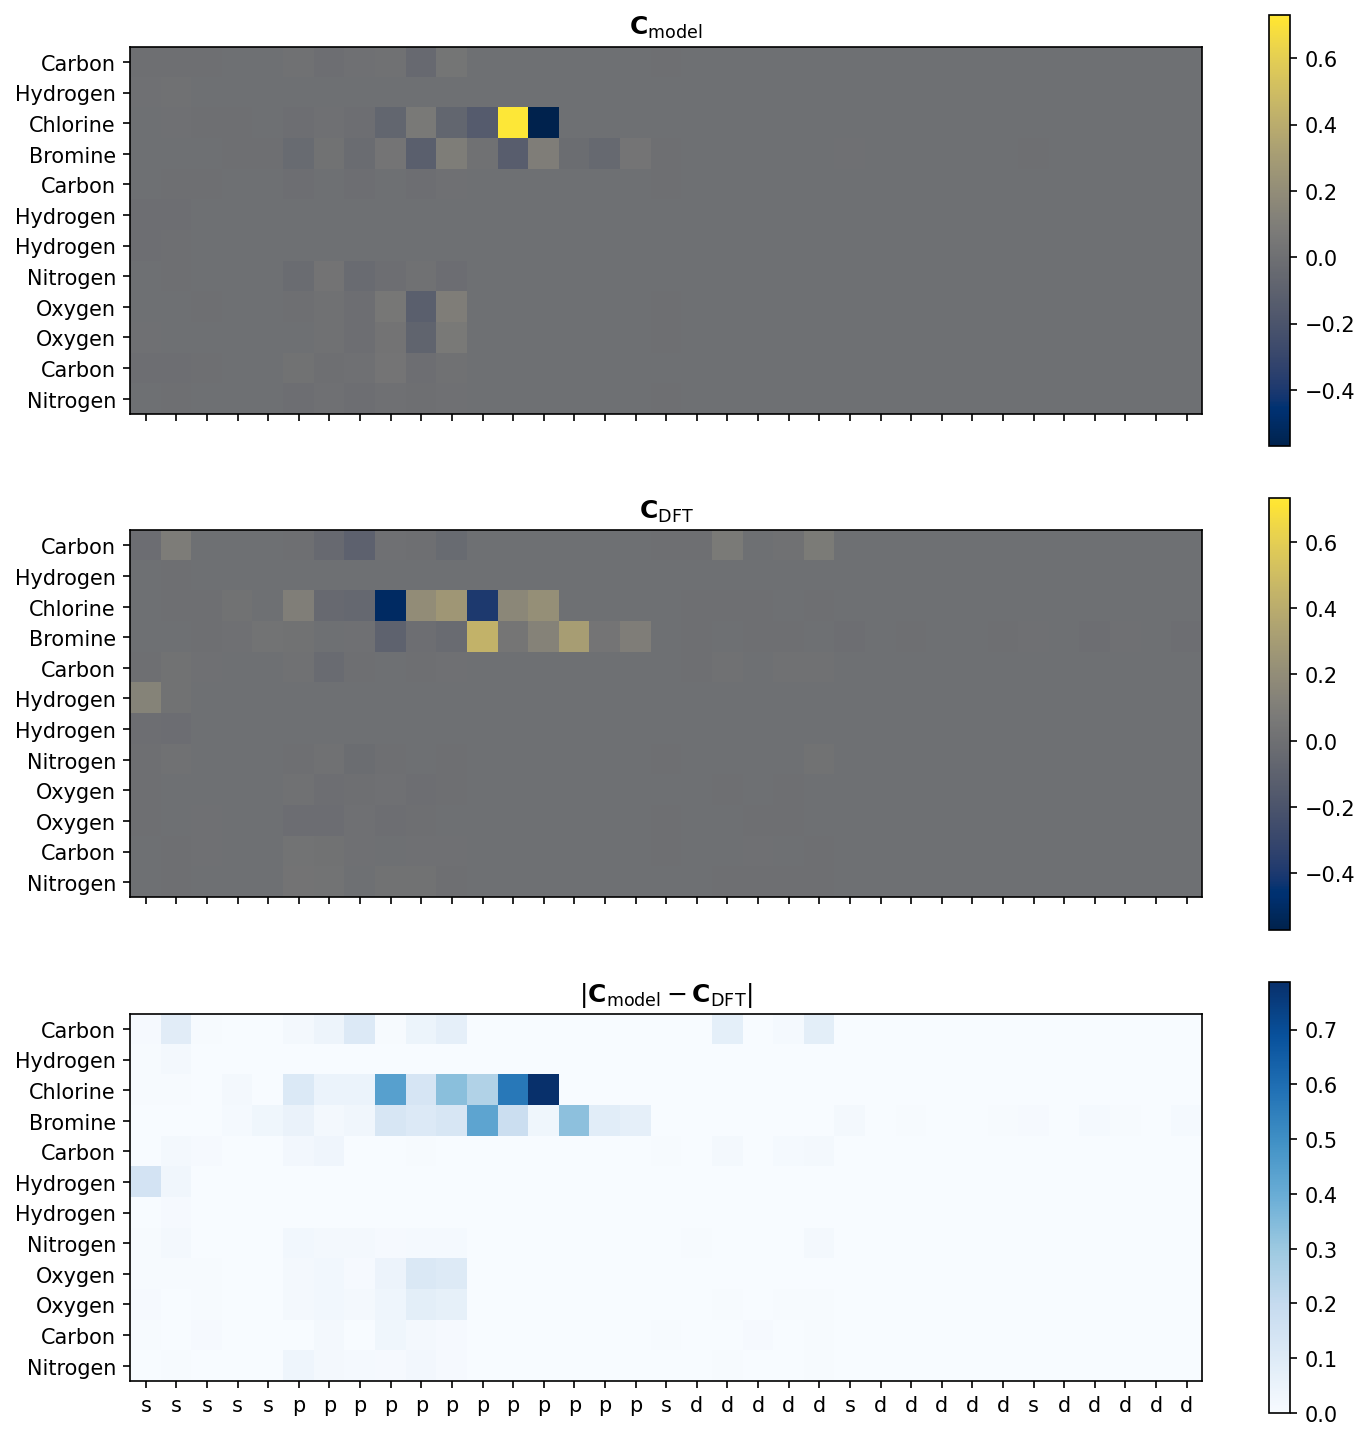

In [12]:
# Read in the model
# model = torch.load("output/reaction_model.pt")
model = torch.load(os.path.join(artifact_dir_coeff, "reaction_model.pt"), map_location=torch.device('cpu'))

for idx, data in enumerate(train_loader):
    output = model(data)
    output = output.detach().numpy()
    sum_squares_ouput = np.sum(output**2)
    print(f"Sum of squares of output: {sum_squares_ouput:.3f}")

    expected = data.x_transition_state.detach().numpy()
    sum_squares_expected = np.sum(expected**2)
    print(f"Sum of squares of expected: {sum_squares_expected:.3f}")

    difference_subtract = output - expected
    difference_add = output + expected
    difference_subtract_max = np.max(np.abs(difference_subtract))
    difference_add_max = np.max(np.abs(difference_add))
    difference = difference_add if difference_add_max < difference_subtract_max else difference_subtract 
    difference = np.abs(difference)
    expected = -expected if difference_add_max < difference_subtract_max else expected
    sum_differences = np.sum(np.abs(difference))
    sumsq_differences = np.sum(difference**2)
    print(f"Sum of differences: {sum_differences:.3f}")
    print(f"Sum of squares of differences: {sumsq_differences:.3f}")
    print(f"Max differences", np.max(np.abs(difference)))

    fig, axs = plt.subplots(3, 1, figsize=(10,10),  sharey=True, sharex=True, facecolor='w')
    cax = axs[0].imshow(output, cmap="cividis")
    fig.colorbar(cax, ax=axs[0])
    axs[0].set_title(r"$\mathbf{C}_{\mathrm{model}}$")
    cax = axs[1].imshow(expected, cmap="cividis")
    fig.colorbar(cax, ax=axs[1])
    cax.set_clim(axs[0].get_images()[0].get_clim())
    axs[1].set_title(r"$\mathbf{C}_{\mathrm{DFT}}$")
    cax = axs[2].imshow(difference, cmap="Blues")
    fig.colorbar(cax, ax=axs[2])
    axs[2].set_title(r"$\left | \mathbf{C}_{\mathrm{model}} - \mathbf{C}_{\mathrm{DFT}} \right | $")

    tickvals = data.species.view(-1).detach().numpy().flatten()
    tickvals_species = [atomic_names[int(tickval)] for tickval in tickvals]
    axs[0].set_yticks(np.arange(len(tickvals)))
    axs[0].set_yticklabels(tickvals_species)
    axs[1].set_yticks(np.arange(len(tickvals)))
    axs[1].set_yticklabels(tickvals_species)
    axs[2].set_yticks(np.arange(len(tickvals)))
    axs[2].set_yticklabels(tickvals_species)
    axs[0].set_xticks(np.arange(35))
    # axs[0].set_xticks(np.arange(4))
    axs[0].set_xticklabels(5 *["s"] + 12*["p"] + 3*["s" , "d" , "d" , "d" , "d" , "d"])
    # axs[0].set_xticklabels(1*["s"] + 3*["p"])
    # axs[0].set_ylabel("Atom Number")
    # axs[1].set_ylabel("Atom Number")
    # axs[2].set_ylabel("Atom Number")
    fig.tight_layout()
    # Improve dpi
    fig.set_dpi(150)
    plt.show()

    break

In [ ]:
all_output_c = []
all_expected_c = []
for idx, data in enumerate(validation_loader_abs):
    output = model(data)
    output = output.detach().numpy()
    output = np.abs(output)
    expected = data.x_transition_state.detach().numpy()

    all_output_c.append(output.flatten())
    all_expected_c.append(expected.flatten())

all_output_c = np.array(all_output_c)
all_expected_c = np.array(all_expected_c)
fig = px.scatter(x=all_output_c, y=all_expected_c)
fig.show()

In [ ]:
# Read in the model
# model = torch.load("output/reaction_model.pt")
model = torch.load(os.path.join(artifact_dir_barrier, "reaction_model.pt"), map_location=torch.device('cpu'))

outputs = []
expecteds = []

for idx, data in enumerate(validation_loader):
    output = model(data)
    output = output.mean(dim=1)
    
    output = output.detach().numpy()
    expected = data.total_energy_transition_state - data.total_energy
    expected = expected.detach().numpy()

    outputs.append(output[0])
    expecteds.append(expected[0])


# Make a parity plot of the output vs. expected
outputs = np.array(outputs).flatten()
expecteds = np.array(expecteds).flatten()
outputs *= ase_units.Ha
expecteds *= ase_units.Ha

# Remove entries from output and expected that less than 0
idx_to_remove = np.where(expecteds < 0)[0]
outputs = np.delete(outputs, idx_to_remove)
expecteds = np.delete(expecteds, idx_to_remove)


# Number of points
print(f"Number of points: {len(outputs)}")
# Determine the mean absolute error
mae = np.mean(np.abs(outputs - expecteds))
print(f"Mean absolute error: {mae:.3f} eV")

fig = px.scatter(x=expecteds, y=outputs, template="simple_white")
# fig.update_layout(title="Parity plot of the output vs. expected barriers")
fig.update_xaxes(title_text="DFT Computed Barrier (eV)")
fig.update_yaxes(title_text="Model Output Barrier (eV)")
# Set x and y axes to be greater than 0
# fig.update_xaxes(range=[0, outputs.max()])
# fig.update_yaxes(range=[0, outputs.max()])
# Draw the parity line
fig.add_shape(
    type="line",
    x0=outputs.min(),
    y0=outputs.min(),
    x1=outputs.max(),
    y1=outputs.max(),
    line=dict(
        color="Red",
        width=4,
        dash="dashdot",
    )
)
# Reduce the aspect ratio
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
)


fig.show()